In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
from munch import Munch
from scipy.linalg import eigvalsh

from QO.general import vec2
from QO.hamiltonians import k_space_H, eigs_over_k

import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 4.0)

from QO.thermodynamics import GCP_contributions, GCP

In [2]:
def k_space_H(t, k, L, m = 1, U = 0, **kwargs):
    """
         | U - 2 t_y cos(k_y - l*phi), -t_x, ...     exp(-ik_xL) |
         | -t_x, .                                            |
     H = | 0   ,                                              |
         | .                                                  |
         | exp(ik_xL)  .....                                  |
         
    I've modified this from the original version to add phi = 2*np.pi*m / L.x so that the phase can wind multiple times in a unit cell.
    """
    phi = 2*np.pi*m / L.x

    #the factor of two along the diagonal comes from  adding the upper and lower triangle together
    upper_triangle = np.diag(U/2 - t.y * np.cos(k.y - np.arange(L.x)*phi), k = 0) \
        - t.x *   np.diag(np.ones(L.x-1), k =  1) \
        + np.exp(-1j * k.x * L.x) * np.diag([1,], k = L.x-1) \
    
    #make hermitian
    H = upper_triangle + upper_triangle.conj().T
    
    return H

def two_band_case(A, B, coupling_gamma = 0, loc = 0):
    """
    Construct a block hamiltonian from two NxN blocks corresponding to subsystems A and B

    H = |A Y|
        |Y B|

    """
    N = A.shape[0]
    Y = np.diag(np.random.normal(loc = loc, scale = coupling_gamma/2, size = N))
    return np.block([[A, Y],
                     [Y, B]])

def eigs_over_k(hamiltonian, N, t, **kwargs):
    """
    This version works for hamiltionians of arbitary shape
    """
    k_xs = np.linspace(-np.pi, np.pi, N.x)
    k_ys = np.linspace(-np.pi, np.pi, N.y)

    internal_DOF = np.atleast_1d(hamiltonian(t, k = vec2(0, 0), **kwargs)).shape[0]
    eigs = np.zeros(shape = (N.x,N.y,internal_DOF))
    for i, k_x in enumerate(k_xs):
        for j, k_y in enumerate(k_ys):
            k = vec2(k_x, k_y)
            H = np.atleast_2d(hamiltonian(t, k, **kwargs))
            eigs[i, j] = eigvalsh(H)
            
    return eigs.flatten()



Doing a sweep over L_x producing a sweep over B
from L_x = 3.0 to l_x = 160.0
using a spacing of 2

(100, 313) (100,) (100, 157) (157,)


[Text(0, 0.5, 'Energy $\\mu$'), Text(0.5, 0, 'F/F0')]

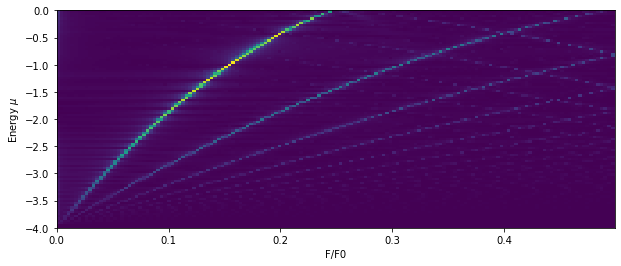

In [3]:
min_phi, max_phi = np.pi / 500, np.pi / 10
min_L_x, max_L_x = np.floor(1 / max_phi), np.ceil(1 / min_phi)
spacing = 2 #set to one to do integer spacing, set to 2 to 1, 3/2, 2, 5/2, set to three to do 1, 4/3, 5/3, 2...

L_x = np.arange(min_L_x * spacing, max_L_x * spacing, dtype = int)

print(f"""
Doing a sweep over L_x producing a sweep over B
from L_x = {min_L_x} to l_x = {max_L_x}
using a spacing of {spacing}
""")

params = Munch(
#hopping parameters in each direction
t = vec2(1,1),

#the number of unit cells to tile in each direction
N = vec2(2, 2),
)  

bins = np.linspace(-5,5,200)
T = 0
B = np.pi * spacing / L_x
Mus = np.linspace(-4,0,100)

GCPs = np.zeros([len(Mus), len(L_x)])

for i, lx in enumerate(L_x):
    #phi = 2*pi*m / L_x
    #if we want to do a grid between phi/2*pi = 1/n and 1/k
    #if spacing = 3 we're doing the sequence phi/2*pi = 2/2n, 2/(2n + 1), 2/(2n + 2), 2/(2n + 3)... 2/(2k),
    #if lx is a multiple of spacing then we can do a simpler calculation with m = 1
    if lx % spacing == 0: 
        m = 1
        lx = lx // spacing
    else:
        m = spacing
        lx = lx
    
    eigs = eigs_over_k(k_space_H, L = vec2(lx, 1), m = m, **params)
    for j, mu in enumerate(Mus):
        GCPs[j, i] = GCP(eigs, mu, T)



dGCP = np.diff(GCPs, axis = -1)
dB = np.diff(B)
M = - dGCP / dB

f, axes = plt.subplots(ncols = 1, figsize = (10,4))

N = len(B)
freqs = np.fft.rfftfreq(M.shape[-1])
ffts = np.fft.rfft(M, axis = -1)
print(M.shape, Mus.shape, ffts.shape, freqs.shape)

axes.pcolormesh(freqs, Mus, np.abs(ffts))

axes.set(ylabel = "Energy $\mu$", xlabel = "F/F0")


Doing a sweep over L_x producing a sweep over B
from L_x = 3.0 to l_x = 160.0
using a spacing of 2

(100, 313) (100,) (100, 157) (157,)


[Text(0, 0.5, 'Energy $\\mu$'), Text(0.5, 0, 'F/F0')]

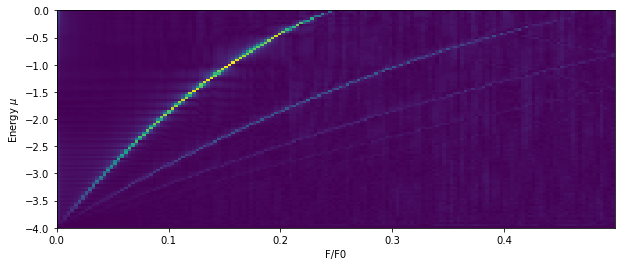

In [4]:
min_phi, max_phi = np.pi / 500, np.pi / 10
min_L_x, max_L_x = np.floor(1 / max_phi), np.ceil(1 / min_phi)
spacing = 2 #set to one to do integer spacing, set to 2 to 1, 3/2, 2, 5/2, set to three to do 1, 4/3, 5/3, 2...

L_x = np.arange(min_L_x * spacing, max_L_x * spacing, dtype = int)

print(f"""
Doing a sweep over L_x producing a sweep over B
from L_x = {min_L_x} to l_x = {max_L_x}
using a spacing of {spacing}
""")
params = Munch(
#hopping parameters in each direction
t = vec2(1,1),

#size of the magnetic unit cell in each direction, L_y = 2 and large L_x means small magenetic field
#L = vec2(10,1),

#the number of unit cells to tile in each direction
N = vec2(10, 10),
)  

bins = np.linspace(-5,5,200)
mu = -1
T = 0
B = np.pi / L_x
Mus = np.linspace(-4,0,100)

GCPs = np.zeros([len(Mus), len(L_x)])

for i, lx in enumerate(L_x):
    #phi = 2*pi*m / L_x
    #if we want to do a grid between phi/2*pi = 1/n and 1/k
    #if spacing = 3 we're doing the sequence phi/2*pi = 2/2n, 2/(2n + 1), 2/(2n + 2), 2/(2n + 3)... 2/(2k),
    #if lx is a multiple of spacing then we can do a simpler calculation with m = 1
    if lx % spacing == 0: 
        m = 1
        lx = lx // spacing
    else:
        m = spacing
        lx = lx
    
    def H_function(t, k, L, m):
        return two_band_case(k_space_H(t, k, L, m), k_space_H(t, k, L, m, offset = -0.5), coupling_gamma = 0.1)
    
    eigs = eigs_over_k(H_function, L = vec2(lx, 1), m = m, **params)
    for j, mu in enumerate(Mus):
        GCPs[j, i] = GCP(eigs, mu, T)



dGCP = np.diff(GCPs, axis = -1)
dB = np.diff(B)
M = - dGCP / dB

f, axes = plt.subplots(ncols = 1, figsize = (10,4))

N = len(B)
freqs = np.fft.rfftfreq(M.shape[-1])
ffts = np.fft.rfft(M, axis = -1)
print(M.shape, Mus.shape, ffts.shape, freqs.shape)

axes.pcolormesh(freqs, Mus, np.abs(ffts))

axes.set(ylabel = "Energy $\mu$", xlabel = "F/F0")

(100, 313) (100,) (100, 157) (157,)


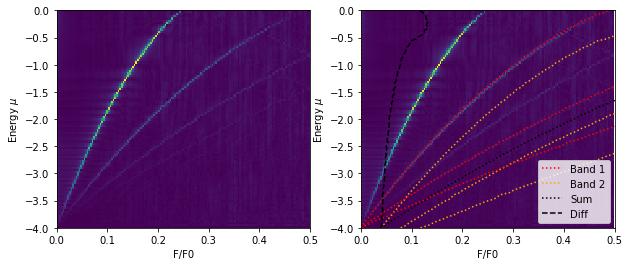

In [5]:
def lattice_dispersion(kx, ky, t = vec2(1,1)): return - 2 * t.x * np.cos(kx) - 2 * t.y * np.cos(ky) 

def FS_area(dispersion, N, E):
    kx = np.linspace(-np.pi, np.pi, N.x)[:, None]
    ky = np.linspace(-np.pi, np.pi, N.y)[None, :]
    sampled_dispersion = dispersion(kx, ky)
    
    dE = E[1] - E[0]
    number_of_states_less_than_E = np.array([np.sum(e > sampled_dispersion) for e in E])
    areas = number_of_states_less_than_E / (N.x * N.y)
    
    return areas

f, axes = plt.subplots(ncols = 2, figsize = (10,4))

N = len(B)
freqs = np.fft.rfftfreq(M.shape[-1])
ffts = np.fft.rfft(M, axis = -1)
print(M.shape, Mus.shape, ffts.shape, freqs.shape)

axes[0].pcolormesh(freqs, Mus, np.abs(ffts))
axes[1].pcolormesh(freqs, Mus, np.abs(ffts))

harmonics = 4
pred = [_,_]
for m in range(harmonics):
    for i, offset, color in zip([0,1], [0, -0.5], ["r", "orange"]):
        pred[i], = axes[1].plot(m*FS_area(lattice_dispersion, vec2(100,100), Mus - offset), Mus, color = color,
                         linestyle = "dotted")
        
s, = axes[1].plot(FS_area(lattice_dispersion, vec2(100,100), Mus) +
                        FS_area(lattice_dispersion, vec2(100,100), Mus - offset), Mus, color = 'k',
                         linestyle = "dotted")

d, = axes[1].plot(-FS_area(lattice_dispersion, vec2(100,100), Mus) +
                        FS_area(lattice_dispersion, vec2(100,100), Mus - offset), Mus, color = 'k',
                         linestyle = "--")
# for m in range(harmonics):
#     for offset in [0, -0.5]:
#         y = np.linspace(-4, 0, 500) - offset
#         x = 1 - m*FS_area(lattice_dispersion, vec2(100,100), y)
#         idx = x < 0.5
#         aliasing, = axes[1].plot(x[idx], y[idx], color = "green", linestyle = "dotted")
    
axes[0].set(ylabel = "Energy $\mu$", xlabel = "F/F0", xlim = (0, 0.5))
axes[1].set(ylabel = "Energy $\mu$", xlabel = "F/F0", xlim = (0, 0.5))

axes[1].legend([pred[0], pred[1], s, d], ["Band 1", "Band 2", "Sum", "Diff"])
f.savefig("two_band.png")